In [1]:
from google.colab import files, drive
drive.mount('/content/drive')
! ln -s drive/MyDrive/CV-Project/dataset ./dataset
! pip install -U -q opencv-python
! pip install -q open3d
! pip install -q pykitti
! pip install -q plotly
! pip install -q evo

Mounted at /content/drive
     |████████████████████████████████| 51.0MB 82kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 300.6MB 48kB/s 
     |████████████████████████████████| 645kB 35.1MB/s 
     |████████████████████████████████| 3.0MB 39.4MB/s 
     |████████████████████████████████| 1.0MB 36.7MB/s 
     |████████████████████████████████| 8.2MB 1.4MB/s 
     |████████████████████████████████| 389kB 56.8MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 430kB 46.5MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERRO

#### PAUSE! MUST RESTART RUNTIME AFTER THE ABOVE PIP INSTALLS BEFORE PROCEEDING FURTHER
---

# Imports and Functions

In [1]:
import cv2
import open3d as o3d
import pykitti
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from typing import *
from time import time


windowSize = 5

stereoParams = {
    'minDisparity': 16,
    'numDisparities': 100,
    'blockSize': 15,
    'P1': 8*3*windowSize**2,
    'P2': 32*3*windowSize**2,
    'disp12MaxDiff': 1,
    'uniquenessRatio': 10,
    # 'speckleWindowSize': 200,
    # 'speckleRange' = 32
}


def writeKitti(poses: List[np.ndarray], filename='stereoVO.txt'):
    with open(filename, 'w') as f:
        for p in poses:
            f.write(f"{' '.join(map(str, p[:3].reshape(-1)))}\n")


def getSIFT(im0: np.ndarray, im1: np.ndarray, nfeatures=None):
    if nfeatures is not None:
        detector = cv2.SIFT_create(nfeatures=nfeatures)
    else:
        detector = cv2.SIFT_create()
    detector = cv2.SIFT_create(nfeatures=nfeatures)
    kp0, des0 = detector.detectAndCompute(im0, None)
    kp1, des1 = detector.detectAndCompute(im1, None)
    return kp0, des0, kp1, des1


def matchFeature(kp0, des0: np.ndarray, kp1, des1: np.ndarray, coeff=0.8, distMeasure=cv2.NORM_L2):
    bf = cv2.BFMatcher(distMeasure)
    pts0 = []
    pts1 = []
    match = []
    for m, n in bf.knnMatch(des0, des1, k=2):
        if m.distance < coeff*n.distance:
            pts0.append(kp0[m.queryIdx].pt)
            pts1.append(kp1[m.trainIdx].pt)
            match.append(1)
        else:
            match.append(0)
    return np.array(pts0), np.array(pts1), np.array(match)


def getStereoPtCloud(im0: np.ndarray, im1: np.ndarray, f: 'focal', b: 'baseline'):
    h, w = im0.shape[:2]

    stereo = cv2.StereoSGBM_create(**stereoParams)
    disp = stereo.compute(im0, im1).astype(np.float32) / 16.0

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0, 1, 0, -0.5*h],
                    [0, 0, 0,     -f],
                    [0, 0, -1/b,   0]])
    points = cv2.reprojectImageTo3D(disp, Q)
    return points[disp > disp.min()]


def plotPath(estPath, truPath, segments=6):
    for i in range(segments):
        j = int(len(estPath) * (i+1) / segments)
        print(f'{j} Points')
        plt.plot(*zip(*map(lambda x: (x[0, 3], x[2, 3]), estPath[:j])), 'go', label='estimate')
        plt.plot(*zip(*map(lambda x: (x[0, 3], x[2, 3]), truPath[:j])), 'ro', label='ground-truth')
        plt.legend()
        plt.show()



dataset = pykitti.odometry('./dataset', '00')
print('calib cam0 intrinsic calibration\n', dataset.calib.K_cam0, '\n')
print('calib cam1 intrinsic calibration\n', dataset.calib.K_cam1, '\n')
print('calib baseline (meters)\n', dataset.calib.b_gray, '\n')
print('calib cam0 projection\n', dataset.calib.P_rect_00, '\n')
print('calib cam1 projection\n', dataset.calib.P_rect_10, '\n')

calib cam0 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib cam1 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib baseline (meters)
 0.5371657081270053 

calib cam0 projection
 [[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]] 

calib cam1 projection
 [[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]] 



# Stereo VO

In [2]:
# Intialization
currPose = np.hstack((np.eye(3), np.zeros((3, 1))))
grImg = iter(dataset.gray)
K = dataset.calib.K_cam0
f = K[0, 0]
baseline = dataset.calib.b_gray
P0, P1 = dataset.calib.P_rect_00, dataset.calib.P_rect_10

In [3]:
# Ok to end mid-run and restart mid-run
# By ending and restarting this cell
print('\nBeginning VO...')
sTime = time()
imA0, imA1 = map(np.array, next(grImg))
ptCloudA = getStereoPtCloud(imA0, imA1, f, baseline)

path = [currPose]
while True:
    print(f'Path Points: {len(path):>5,}; Loop Time: {time() - sTime:.2f}')

    imB0, imB1 = imA0, imA1
    ptCloudB = ptCloudA

    sTime = time()
    try:
        imA0, imA1 = map(np.array, next(grImg))
        ptCloudA = getStereoPtCloud(imA0, imA1, f, baseline)
    except StopIteration:
        break

    kpA, desA, kpB, desB = getSIFT(imA0, imB0, nfeatures=600)
    ptsA, ptsB, match = matchFeature(kpA, desA, kpB, desB)
    E, inliers = cv2.findEssentialMat(ptsA, ptsB, K, cv2.RANSAC, prob=0.9999,
                                        threshold=0.25)  # RANSAC bad when threshold is too tight
    _, R, t, inliers = cv2.recoverPose(E, ptsA, ptsB, K, mask=inliers)

    trans_init = np.vstack((np.hstack((R, t)), np.array([0.0, 0.0, 0.0, 1.0])))

    src = o3d.geometry.PointCloud()
    src.points = o3d.utility.Vector3dVector(ptCloudB)

    tar = o3d.geometry.PointCloud()
    tar.points = o3d.utility.Vector3dVector(ptCloudA)

    reg_p2p = o3d.pipelines.registration.registration_icp(
        src, tar, 0.02, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())

    currPose = currPose @ reg_p2p.transformation
    path.append(currPose)

writeKitti(path, 'stereoVO_hybrid.txt')
! mv monovoDH1.txt drive/MyDrive/CV-Project/monoVO.txt      # Save results


Beginning VO...
Path Points:     1; Loop Time: 2.02
Path Points:     2; Loop Time: 16.49
Path Points:     3; Loop Time: 16.98
Path Points:     4; Loop Time: 16.62
Path Points:     5; Loop Time: 16.98
Path Points:     6; Loop Time: 16.91
Path Points:     7; Loop Time: 16.75
Path Points:     8; Loop Time: 16.58
Path Points:     9; Loop Time: 16.40
Path Points:    10; Loop Time: 16.36
Path Points:    11; Loop Time: 16.47
Path Points:    12; Loop Time: 16.55
Path Points:    13; Loop Time: 17.04
Path Points:    14; Loop Time: 16.73
Path Points:    15; Loop Time: 16.71
Path Points:    16; Loop Time: 16.50
Path Points:    17; Loop Time: 16.17
Path Points:    18; Loop Time: 16.53
Path Points:    19; Loop Time: 16.69
Path Points:    20; Loop Time: 13.96
Path Points:    21; Loop Time: 16.64
Path Points:    22; Loop Time: 16.74
Path Points:    23; Loop Time: 16.66
Path Points:    24; Loop Time: 16.34
Path Points:    25; Loop Time: 16.79
Path Points:    26; Loop Time: 16.72


KeyboardInterrupt: ignored

13 Points


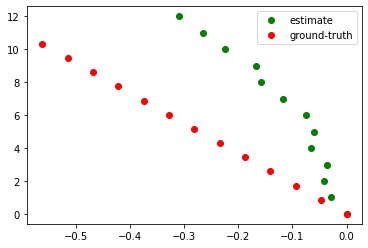

26 Points


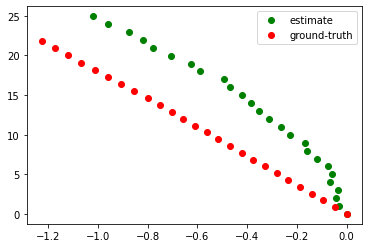

In [4]:
plotPath(path, dataset.poses, segments=2)